In [1]:
import numpy as np
import pandas as pd
from scipy.sparse import hstack, csc_matrix
from scipy.sparse.linalg import svds
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.set_style('whitegrid')

In [2]:
%%time

train_df = pd.read_hdf('../input/X_train_add_supplement.h5', 'table')
test_df = pd.read_hdf('../input/X_test_add_supplement.h5', 'table')

CPU times: user 24.9 s, sys: 17.4 s, total: 42.3 s
Wall time: 42.3 s


In [4]:
def dummy_variable(df):
    n_samples = df.shape[0]
    feature_names = df.columns
    
    onehot_features = []
    column_names = []
    for c_name in df.columns:
        n_uniq_categories = df[c_name].max() + 1

        nnz_i = np.arange(n_samples, dtype=np.int32)
        nnz_j = df[c_name].astype(np.int32)
        onehot = csc_matrix(
            (np.ones(len(nnz_i)), (nnz_i, nnz_j)),
            shape=(n_samples, n_uniq_categories)
        )

        onehot_features.append(onehot)
        column_names.append(
            [c_name + str(category) for category in np.arange(n_uniq_categories)]
        )
        
    onehot_features = hstack(onehot_features)
    column_names = list(itertools.chain.from_iterable(column_names))
    
    return onehot_features, column_names

In [5]:
%%time

columns = ['app', 'channel', 'device', 'day', 'hour', 'os']

dummy_mat, column_names = dummy_variable(
    train_df.append(test_df)[columns]
)

CPU times: user 2min 31s, sys: 2min 27s, total: 4min 58s
Wall time: 2min 28s


In [6]:
n_positive = train_df[train_df.is_attributed == 1].shape[0]

neg_idx = train_df[train_df.is_attributed == 0].index.to_series().sample(
    n_positive, replace=False
).values
pos_idx = train_df[train_df.is_attributed == 1].index.to_series().values

sample_idx = np.concatenate([pos_idx, neg_idx])

In [7]:
dummy_mat_sample = dummy_mat[:train_df.shape[0]][sample_idx]

In [8]:
u, s, vt = svds(dummy_mat_sample, k=100)

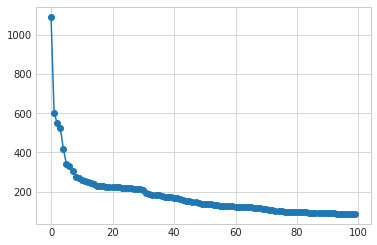

In [9]:
plt.plot(s[::-1], 'o-')

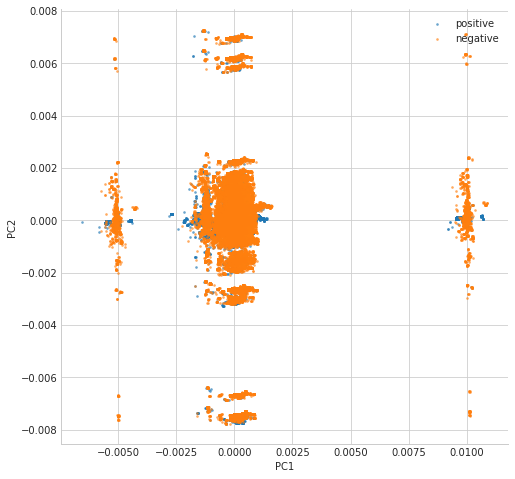

In [10]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.set_style('white')
sns.regplot(
    x='PC1', y='PC2',
    data=pd.DataFrame(u[:n_positive, 1:3], columns=['PC1', 'PC2']),
    fit_reg=False,
    scatter_kws={'s': 3, 'alpha': 0.5},
    label='positive'
)

sns.regplot(
    x='PC1', y='PC2',
    data=pd.DataFrame(u[n_positive:, 1:3], columns=['PC1', 'PC2']),
    fit_reg=False,
    scatter_kws={'s': 3, 'alpha': 0.5},
    label='negative'
)

plt.legend()
sns.despine()

/home/g8da_tetsuya/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


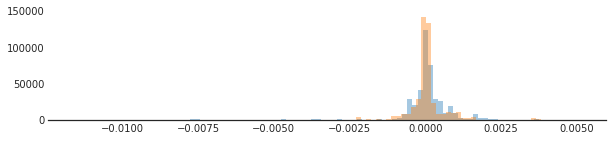

In [11]:
plt.subplots(figsize=(10, 2))

sns.distplot(u[:n_positive, 0], bins=100, kde=False)
sns.distplot(u[n_positive:, 0], bins=100, kde=False)

sns.despine(left=True)

In [14]:
pc = dummy_mat.dot(vt[1]) # ignore singular value

In [15]:
train_df['pc'] = pc[:train_df.shape[0]]
test_df['pc'] = pc[train_df.shape[0]:]

In [17]:
train_df.to_hdf("../input/X_train_pc.h5", 'table', complib='blosc', complevel=9)
test_df.to_hdf("../input/X_test_pc.h5", 'table', complib='blosc', complevel=9)